In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [222]:
## read the tsv files in MovieSummaries
load_movies = pd.read_csv('MovieSummaries/movie.metadata.tsv', sep = '\t', header = None)
load_character = pd.read_csv('MovieSummaries/character.metadata.tsv', sep = '\t', header = None)


In [223]:
movies = load_movies.copy()
character = load_character.copy()


In [224]:
# Make the name of the colum of movie: wikip_ID, freebase_ID, name, release date, box office, runtime, languages, countries, genres	
movies.columns = ['Wiki_ID', 'Freebase_ID', 'name', 'release_date', 'box_office', 'runtime', 'languages', 'countries', 'genres']
# Make the name of the columns of character wiki_ID, freebase_ID, character_name, actor_DOB, actor_gender, actor_height, actor_ethnicity, actor_name, actor_age, freebase_character_map
character.columns = ['Wiki_ID', 'Freebase_ID','release_date', 'character_name', 'actor_DOB', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 'actor_age', '10', '11', '12']
character = character.drop(['10', '11', '12'], axis = 1)

In [225]:
## read grossed merged clean csv
gross = pd.read_csv('gross_merged_clean.csv')
gross

,tconst,Wiki_ID,Freebase_ID,country,movie,gross
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0
...,...,...,...,...,...,...
90661,tt0120202,1918494,/m/0660qx,Denmark,state and main,13732.0
90662,tt0120202,1918494,/m/0660qx,Australia,state and main,385631.0
90663,tt0107057,664006,/m/030xw6,Domestic,guilty as sin,22866222.0
90664,tt1606259,34980460,/m/0g4pl34,Domestic,knuckle,2647.0


## Question 1

For The first question we will need the gross of the movies in the different region of the world, as well as their release year and their genre.


In [226]:
movies_clean_gross = movies.copy()
gross_clean = gross.copy()

# Sum up the gross for each movie in the `gross` dataframe
gross_sum = gross_clean.groupby('Wiki_ID')['gross'].sum().reset_index()

# Merge this sum with the `movies` dataframe
movies_with_gross = movies_clean_gross.merge(gross_sum, on='Wiki_ID', how='left')

# Filter out rows where 'box_office' is not missing
non_missing_box_office = movies_with_gross.dropna(subset=['box_office'])


missing_percentage_before = movies_with_gross['box_office'].isna().sum() / len(movies_with_gross) * 100
print(f"Percentage of missing 'box_office' values before imputation: {missing_percentage_before:.2f}%")

# Check coherence for non-missing 'box_office' values
coherence_check = ((non_missing_box_office['box_office'] - non_missing_box_office['gross']).abs() / non_missing_box_office['box_office']).mean()
print(f"Average coherence deviation: {coherence_check:.2f}")


Percentage of missing 'box_office' values before imputation: 89.72%
Average coherence deviation: 0.34


There are a lot of box_office missing values, and for the ones we have, the summed gross differ from it by 34%, so replacing the Nans by the summed gross will not be accurate.

Instead, we should use the summed gross as the global box office for all the movies, and we can drop the box_office feature.

In [227]:
movies_with_gross = movies_with_gross.drop(columns=['box_office'])

In [228]:
# The release date of the movie is in the format of YYYY-MM-DD, we only need the year 
# so we split the date and only keep the year
movies_clean_release = movies_with_gross.copy()
movies_clean_release['release_date'] = movies_clean_release['release_date'].str[:4]
movies_clean_release['release_date'] = pd.to_numeric(movies_clean_release['release_date'], errors='coerce')
# Here the errors ignore is to keep the nan in the release date column
movies_clean_release['release_date'] = movies_clean_release['release_date'].astype(np.int64, errors='ignore')

In [229]:
movies_clean_genre = movies_clean_release.copy()
movies_clean_genre['genres'] = movies_clean_genre['genres'].apply(lambda x: list(ast.literal_eval(x).values()))
# This line is to make the empty list to be nan so the nan are uniform
movies_clean_genre['genres'] = movies_clean_genre['genres'].apply(lambda x: x if len(x) != 0 else np.nan)


In [230]:
gross_genre_release = gross_clean.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_genre_release = gross_genre_release.merge(movies_clean_genre[['Wiki_ID', 'release_date', 'genres']], on = 'Wiki_ID', how = 'left')


In [231]:
# count the numers of nan in genre
missing_genre_value = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].isna().sum()/gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].shape[0]*100
print('The percentage of missing values in the genre column is {:.2f}%'.format(missing_genre_value))

The percentage of missing values in the genre column is 0.14%


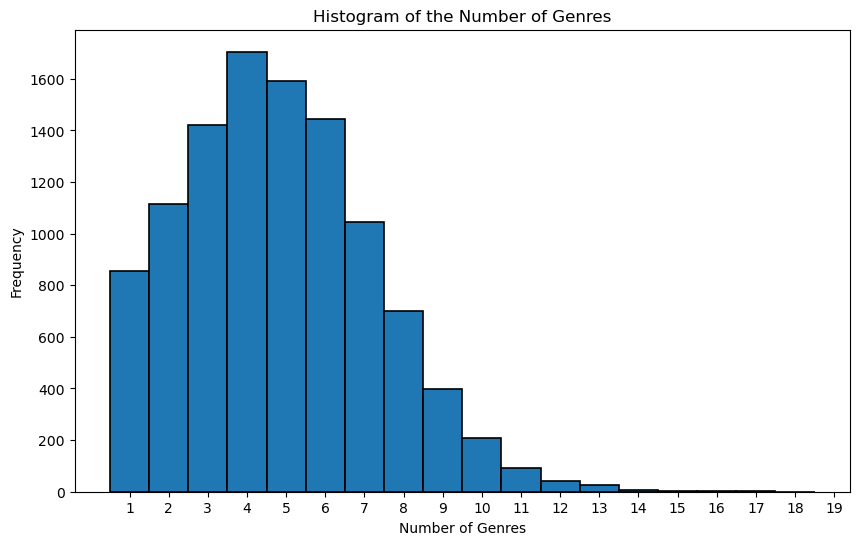

In [232]:
number_of_genres = gross_genre_release.drop_duplicates(subset='Wiki_ID')['genres'].dropna().apply(lambda x: len(x))
# histogram of the number of genres
plt.figure(figsize=(10, 6))
plt.hist(number_of_genres,bins = np.arange(1, 20, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Genres')
plt.xticks(np.arange(1, 20, 1))
plt.ylabel('Frequency')
plt.title('Histogram of the Number of Genres')
plt.show()

We have a very low percentage of genre missing we can therefore have a good analysis about this metric. We don't have any missing values for the release date because it was used as a key when merging the IMdB dataset with the CMU datset

## Question 3 

In [233]:
movies_clean_country = movies_clean_genre.copy()
movies_clean_country['countries'] = movies_clean_country['countries'].apply(lambda x: list(ast.literal_eval(x).values()))
# This line is to make the empty list to be nan so the nan are uniform
movies_clean_country['countries'] = movies_clean_country['countries'].apply(lambda x: x if len(x) != 0 else np.nan)

In [234]:
gross_country = gross_genre_release.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_country = gross_country.merge(movies_clean_country[['Wiki_ID', 'countries']], on = 'Wiki_ID', how = 'left')

In [235]:
# count the numers of nan in countries
missing_country_value = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].isna().sum()/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100
print('The percentage of missing values in the countries column is {:.2f}%'.format(missing_country_value))

The percentage of missing values in the countries column is 1.70%


In [236]:
coprood_count = gross_country.dropna(subset='countries')
coprood_count = coprood_count.drop_duplicates(subset='Wiki_ID')[coprood_count['countries'].apply(lambda x: len(x)) > 1].shape[0]/gross_country.drop_duplicates(subset='Wiki_ID')['countries'].shape[0]*100

print('The number of movies that are co-produced by more than one country is {:.2f}%'.format(coprood_count))

The number of movies that are co-produced by more than one country is 24.98%


/var/folders/hg/m_l4_1m14_n0nfz7gdn_lbdw0000gn/T/ipykernel_70551/30425266.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



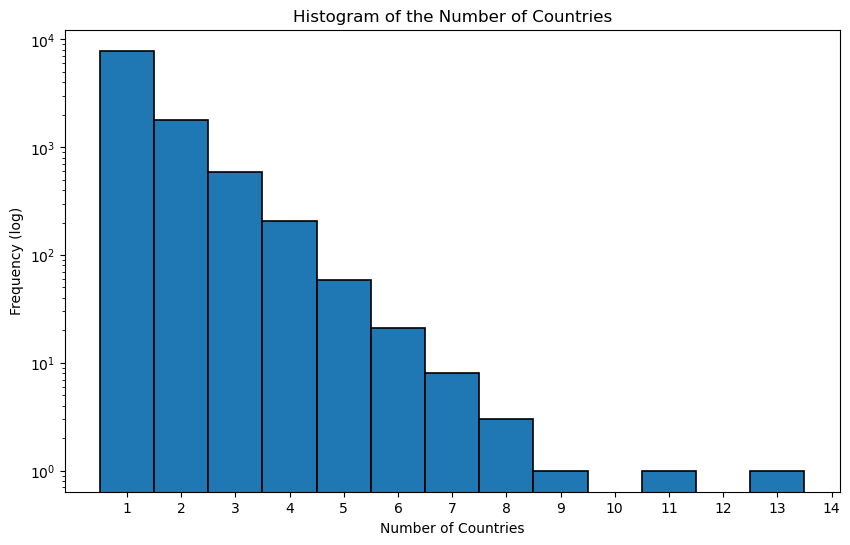

In [237]:
number_of_countries = gross_country.drop_duplicates(subset='Wiki_ID')['countries'].dropna().apply(lambda x: len(x))
# histogram of the number of production countries
plt.figure(figsize=(10, 6))
plt.hist(number_of_countries,bins = np.arange(1, 15, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Countries')
plt.xticks(np.arange(1, 15, 1))
plt.yscale('log')
plt.ylabel('Frequency (log)')
plt.title('Histogram of the Number of Countries')
plt.show()

We have a very low percentage of countries missing we can therefore have a good analysis about this metric. And the level of co-production is relatively high so it will still make sense to do our analysis.

## Question 4

For the gender representation in the movie. We decided to only use the values that were given for each of the movies, making the assumption that if the gender of an actor is not given the character was probably a small part. 

In [238]:
# go in the character dataset and find the percentage of gender F in each movie
character_gender = character.copy()

#count the number of "F" for each wiki_ID in character_gender
# groupby wiki_ID and count the number of "F" in each group
character_groupby = character_gender.groupby('Wiki_ID')
character_groupby_tot = character_groupby["actor_gender"].count()
character_groupby_F = character_groupby.apply(lambda x: (x['actor_gender'] == 'F').sum())
ratio_female_to_total = character_groupby_F / character_groupby_tot



In [239]:
data = {
    'Wiki_ID': ratio_female_to_total.index,
    'Ratio_Female_to_Total': ratio_female_to_total.values
}

# Create DataFrame
df_ratio = pd.DataFrame(data)

# Reset the index to make it 1-dimensional
df_ratio.reset_index(drop=True, inplace=True)

In [240]:
movies_clean_gender = movies_clean_country.copy()
movies_clean_gender = movies_clean_gender.merge(df_ratio, on = 'Wiki_ID', how = 'left')
movies_clean_gender.head()

,Wiki_ID,Freebase_ID,name,release_date,runtime,languages,countries,genres,gross,Ratio_Female_to_Total
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",11996794.0,0.352941
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN,0.266667
2,28463795,/m/0crgdbh,Brun bitter,1988.0,83.0,"{""/m/05f_3"": ""Norwegian Language""}",[Norway],"[Crime Fiction, Drama]",NaN,0.500000
3,9363483,/m/0285_cd,White Of The Eye,1987.0,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",NaN,0.500000
4,261236,/m/01mrr1,A Woman in Flames,1983.0,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],NaN,0.333333


In [241]:
gross_gender = gross_country.copy()
#merge gross and movies_clean_genre on wiki_ID
gross_gender = gross_gender.merge(movies_clean_gender[['Wiki_ID', 'Ratio_Female_to_Total']], on = 'Wiki_ID', how = 'left')
gross_gender

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,genres,countries,Ratio_Female_to_Total
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],0.352941
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],0.352941
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],0.352941
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],0.352941
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,"[Thriller, Science Fiction, Horror, Adventure,...",[United States of America],0.352941
...,...,...,...,...,...,...,...,...,...,...
90661,tt0120202,1918494,/m/0660qx,Denmark,state and main,13732.0,2000.0,"[Parody, Americana, Comedy]","[France, United States of America]",0.181818
90662,tt0120202,1918494,/m/0660qx,Australia,state and main,385631.0,2000.0,"[Parody, Americana, Comedy]","[France, United States of America]",0.181818
90663,tt0107057,664006,/m/030xw6,Domestic,guilty as sin,22866222.0,1993.0,"[Thriller, Erotic thriller, Psychological thri...",[United States of America],0.375000
90664,tt1606259,34980460,/m/0g4pl34,Domestic,knuckle,2647.0,2011.0,"[Biographical film, Drama, Documentary]","[Ireland, United Kingdom]",NaN


In [242]:
# Analyzing Ethnicity Data
print(f"Total entries in character dataframe: {len(character)}")

# Check for missing values in 'actor_ethnicity'
missing_ethnicity = character['actor_ethnicity'].isna().sum()
print(f"Number of missing values in 'actor_ethnicity': {missing_ethnicity}")
print(f"Percentage of missing values in 'actor_ethnicity': {missing_ethnicity / len(character) * 100:.2f}%")

Total entries in character dataframe: 450669
Number of missing values in 'actor_ethnicity': 344611
Percentage of missing values in 'actor_ethnicity': 76.47%


In [243]:
#Filling Nan with 'Unknown' ethnicity
character_ethnicity = character_gender.copy()
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity']

# Analyzing ethnicity distribution
ethnicity_distribution = character['actor_ethnicity'].value_counts(normalize=True) * 100
print(ethnicity_distribution)

actor_ethnicity
/m/0dryh9k    15.417036
/m/0x67        9.578721
/m/041rx       9.542892
/m/02w7gg      5.812857
/m/033tf_      3.636689
                ...    
/m/043_z22     0.000943
/m/03x_fq7     0.000943
/m/01hphz      0.000943
/m/033fjj      0.000943
/m/013y54      0.000943
Name: proportion, Length: 479, dtype: float64


We have the distribution of the ethnicities, but they are encoded as ids. Lets decode them :

In [244]:
# Load the CSV file into a DataFrame
ethnicity_labels_df = pd.read_csv('dictionnaries/ethnicity_labels.csv')

# Convert the DataFrame to a dictionary
ethnicity_labels = dict(zip(ethnicity_labels_df['Freebase ID'], ethnicity_labels_df['Ethnicity Label']))

# Replace the codes in 'ethnicity_distribution' with their labels
ethnicity_distribution_labeled = ethnicity_distribution.rename(index=ethnicity_labels)

# Print the updated distribution
print(ethnicity_distribution_labeled)

actor_ethnicity
Indian person             15.417036
African Americans          9.578721
Jewish people              9.542892
English people             5.812857
Irish Americans            3.636689
                            ...    
/m/043_z22                 0.000943
Aboriginal Australians     0.000943
Indian diaspora            0.000943
Ho-Chunk                   0.000943
Han Chinese people         0.000943
Name: proportion, Length: 479, dtype: float64


We can see that some ethnicities aren't translated. Lets analyse them.

In [245]:
# Identifying untranslated ethnicity codes
untranslated_codes = set(character_ethnicity['actor_ethnicity']) - set(ethnicity_labels.keys())
untranslated_codes = {code for code in untranslated_codes if isinstance(code, str)}  # Ensure that NaNs are not included

# Counting the number of untranslated ethnicities
untranslated_counts = character_ethnicity['actor_ethnicity'].apply(lambda x: x if x in untranslated_codes else np.nan).value_counts()

character_ethnicity_df = character_ethnicity.copy()

# Find the most common untranslated ethnicity
if not untranslated_counts.empty:
    most_common_untranslated = untranslated_counts.idxmax()
    most_common_untranslated_count = untranslated_counts.max()
    print(f"Most common untranslated ethnicity: {most_common_untranslated} ({most_common_untranslated_count} occurrences)")

    print("Five most common untranslated ethnicities:")
    print(untranslated_counts.head(5))

else:
    print("No untranslated ethnicity codes found.")

Most common untranslated ethnicity: /m/044038p (1885 occurrences)
Five most common untranslated ethnicities:
actor_ethnicity
/m/044038p    1885
/m/02p1pl6     200
/m/04tvpv      197
/m/02p656s     121
/m/0283js_      81
Name: count, dtype: int64


There are 1885 actors with ethnicity '/m/044038p'. Lets see who they are.

In [246]:
# Filter for actors with the specified ethnicity code
actors_with_specific_ethnicity = character_ethnicity[character_ethnicity['actor_ethnicity'] == '/m/044038p']

# Select 10 actors from this group
sample_actors = actors_with_specific_ethnicity.sample(10)

# Print the selected actors
print(sample_actors[['actor_name', 'actor_ethnicity']])

                 actor_name actor_ethnicity
362601         Jessica Paré      /m/044038p
133914        Wendy Crewson      /m/044038p
180654  Christopher Plummer      /m/044038p
239161           Ellen Page      /m/044038p
2805             Len Cariou      /m/044038p
98997         Kirsten Prout      /m/044038p
424825           Dave Foley      /m/044038p
210079            Greg Bryk      /m/044038p
416947          Ellen David      /m/044038p
444321    Peter Outerbridge      /m/044038p


Those 10 actors are all canadians. We will call this ethnicity 'Canadians'.

In [247]:
# Define a function to replace unknown ethnicities
def replace_unknown_ethnicities(ethnicity):
    if ethnicity == '/m/044038p':
        return 'Canadians'
    elif not ethnicity in ethnicity_labels.keys():
        return 'Unknown'
    else:
        return ethnicity

# Apply the function to the actor_ethnicity column
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity'].apply(replace_unknown_ethnicities)

print(character_ethnicity.head())

   Wiki_ID Freebase_ID release_date              character_name   actor_DOB  \
0   975900   /m/03vyhn   2001-08-24                    Akooshay  1958-08-26   
1   975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard  1974-08-15   
2   975900   /m/03vyhn   2001-08-24         Desolation Williams  1969-06-15   
3   975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler  1967-09-12   
4   975900   /m/03vyhn   2001-08-24             Bashira Kincaid  1977-09-25   

  actor_gender  actor_height actor_ethnicity          actor_name  actor_age  
0            F         1.620         Unknown      Wanda De Jesus       42.0  
1            F         1.780       Canadians  Natasha Henstridge       27.0  
2            M         1.727         /m/0x67            Ice Cube       32.0  
3            M         1.750         Unknown       Jason Statham       33.0  
4            F         1.650         Unknown         Clea DuVall       23.0  


In [248]:
# Replace 'Unknown' with np.nan in the actor_ethnicity column
character_ethnicity['actor_ethnicity'] = character_ethnicity['actor_ethnicity'].replace('Unknown', np.nan)

# Optionally, print a few rows to verify the changes
print(character_ethnicity.head())

   Wiki_ID Freebase_ID release_date              character_name   actor_DOB  \
0   975900   /m/03vyhn   2001-08-24                    Akooshay  1958-08-26   
1   975900   /m/03vyhn   2001-08-24  Lieutenant Melanie Ballard  1974-08-15   
2   975900   /m/03vyhn   2001-08-24         Desolation Williams  1969-06-15   
3   975900   /m/03vyhn   2001-08-24          Sgt Jericho Butler  1967-09-12   
4   975900   /m/03vyhn   2001-08-24             Bashira Kincaid  1977-09-25   

  actor_gender  actor_height actor_ethnicity          actor_name  actor_age  
0            F         1.620             NaN      Wanda De Jesus       42.0  
1            F         1.780       Canadians  Natasha Henstridge       27.0  
2            M         1.727         /m/0x67            Ice Cube       32.0  
3            M         1.750             NaN       Jason Statham       33.0  
4            F         1.650             NaN         Clea DuVall       23.0  


In [249]:
def extract_languages(lang_str):
    if pd.isna(lang_str):
        return ['Unknown']
    try:
        # Parse the string as a dictionary
        lang_dict = ast.literal_eval(lang_str)
        # Extract the language names and remove 'Language' from the end
        languages = [lang.split(' Language')[0] for lang in lang_dict.values()]

        return languages
    except ValueError:
        # Handle cases where lang_str cannot be parsed
        return ['Unknown']

movies_clean_languages = movies_clean_country.copy()
movies_clean_languages['languages'] = movies_clean_languages['languages'].apply(extract_languages)

# Counting languages
language_counts = pd.Series([lang for sublist in movies_clean_languages['languages'] for lang in sublist]).value_counts()
print(language_counts)

English                                 40891
Hindi                                    3744
Spanish                                  3673
French                                   3422
Silent film                              3183
                                        ...  
Southwestern Mandarin                       1
Australian Aboriginal Pidgin English        1
Krio                                        1
Pawnee                                      1
Kuna language                               1
Name: count, Length: 205, dtype: int64


In [250]:
gross_language = gross_gender.copy()
#merge gross_gender and movies_clean_language on wiki_ID
gross_language = gross_language.merge(movies_clean_languages[['Wiki_ID', 'languages']], on = 'Wiki_ID', how = 'left')

In [251]:
# Count the number of movies with more than one language
multilingual_movies = movies_clean_languages['languages'].apply(lambda x: len(x) > 1)

print(f"Number of multilingual movies: {multilingual_movies.sum()} over {len(multilingual_movies)} movies.")
print(movies_clean_languages['languages'][multilingual_movies].head())

Number of multilingual movies: 9807 over 81741 movies.
5     [Silent film, English]
48    [Silent film, English]
49      [Afrikaans, English]
51    [Silent film, English]
52    [Silent film, English]
Name: languages, dtype: object


In [252]:
# Creating a new dataframe for multilingual movies for language combination analysis
multilingual_combinations_df = movies_clean_languages.copy()
multilingual_combinations_df = multilingual_combinations_df[multilingual_combinations_df['languages'].apply(lambda x: len(x) > 1 and 'Unknown' not in x)]

# Create a distinct identifier for each multilingual language combination
multilingual_combinations_df['multilingual_combination'] = multilingual_combinations_df['languages'].apply(lambda x: '-'.join(sorted(x)))

# Count the occurrences of each multilingual language combination
multilingual_combination_counts = multilingual_combinations_df['multilingual_combination'].value_counts()
print("Most common multilingual language combinations:")
print(multilingual_combination_counts.head())  # Adjust the number of combinations to display as needed


Most common multilingual language combinations:
multilingual_combination
English-Silent film    2297
English-French          522
English-Spanish         506
English-Italian         278
English-German          264
Name: count, dtype: int64


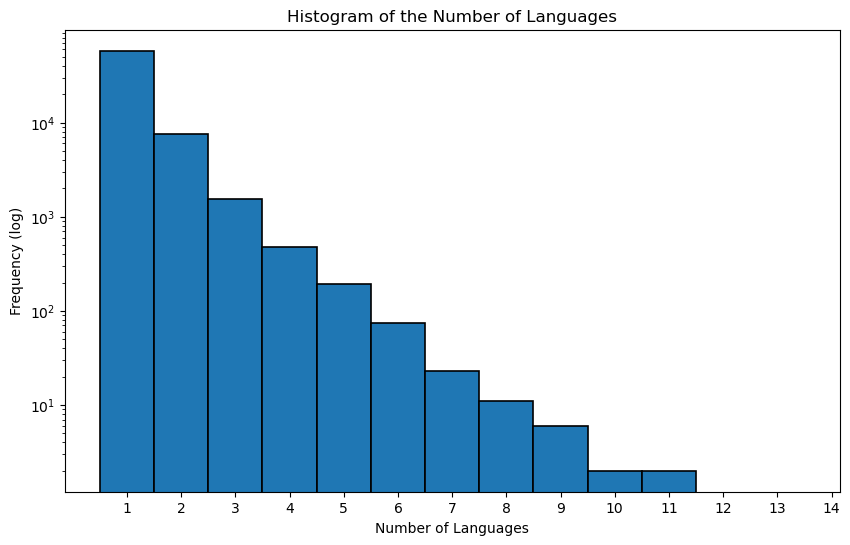

In [253]:
number_of_languages = movies_clean_languages.drop_duplicates(subset='Wiki_ID')['languages'].dropna().apply(lambda x: len(x))
# histogram of the number of genres
plt.figure(figsize=(10, 6))
plt.hist(number_of_languages,bins = np.arange(1, 15, 1)-0.5, edgecolor = 'black', linewidth = 1.2)
plt.xlabel('Number of Languages')
plt.xticks(np.arange(1, 15, 1))
plt.ylabel('Frequency (log)')
plt.yscale('log')
plt.title('Histogram of the Number of Languages')
plt.show()

# Analysis

In [254]:
movies_clean_languages.columns

Index(['Wiki_ID', 'Freebase_ID', 'name', 'release_date', 'runtime',
       'languages', 'countries', 'genres', 'gross'],
      dtype='object')

In [255]:
movies_clean_languages.head()

,Wiki_ID,Freebase_ID,name,release_date,runtime,languages,countries,genres,gross
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",11996794.0
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",NaN
2,28463795,/m/0crgdbh,Brun bitter,1988.0,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",NaN
3,9363483,/m/0285_cd,White Of The Eye,1987.0,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",NaN
4,261236,/m/01mrr1,A Woman in Flames,1983.0,106.0,[German],[Germany],[Drama],NaN


In [256]:
import ast

# Load the CSV file
csv_file_path = 'dictionnaries/movies_genres.csv'
new_genre_df = pd.read_csv(csv_file_path)

# Convert the 'genres' from string to list
new_genre_df['genres'] = new_genre_df['genres'].apply(ast.literal_eval)

# Merge with the original DataFrame
gross_language = gross_language.drop('genres', axis=1, errors='ignore').merge(new_genre_df, on='Wiki_ID')

# Display the merged DataFrame
gross_language.head()

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,countries,Ratio_Female_to_Total,languages,genres
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."


In [257]:
gross_language.columns

Index(['tconst', 'Wiki_ID', 'Freebase_ID', 'country', 'movie', 'gross',
       'release_date', 'countries', 'Ratio_Female_to_Total', 'languages',
       'genres'],
      dtype='object')

In [258]:
gross_language.head()

,tconst,Wiki_ID,Freebase_ID,country,movie,gross,release_date,countries,Ratio_Female_to_Total,languages,genres
0,tt0228333,975900,/m/03vyhn,Domestic,ghosts of mars,8709640.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
1,tt0228333,975900,/m/03vyhn,France,ghosts of mars,1937390.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
2,tt0228333,975900,/m/03vyhn,Spain,ghosts of mars,509536.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
3,tt0228333,975900,/m/03vyhn,Germany,ghosts of mars,496679.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."
4,tt0228333,975900,/m/03vyhn,United Kingdom,ghosts of mars,148898.0,2001.0,[United States of America],0.352941,[English],"[Thriller, Adventure, Action, Science Fiction,..."


In [259]:
import networkx as nx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path

In [260]:
cleaned_df = gross_language[['Freebase_ID', 'movie', 'country', 'gross', 'countries', 'genres']].copy()
cleaned_df = cleaned_df[~cleaned_df['countries'].isna()]

In [261]:
country_to_region_df = pd.read_csv('dictionnaries/country_to_region.csv')
country_to_region_dict = dict(zip(country_to_region_df['Country'], country_to_region_df['Region']))

In [262]:
cmu_to_imdb_df = pd.read_csv('dictionnaries/CMU_to_IMDB.csv')
cmu_to_imdb_dict = dict(zip(cmu_to_imdb_df['Country_mapped'], cmu_to_imdb_df['Country']))

In [263]:
cleaned_df['coprod'] = cleaned_df['countries'].apply(lambda x: [cmu_to_imdb_dict[country] for country in x])

In [264]:
# Step 1: Divide box office equally among co-production countries
cleaned_df['divided_gross'] = cleaned_df.apply(lambda row: row['gross'] / len(row['coprod']) if row['coprod'] else 0, axis=1)

# Step 2: Explode the DataFrame based on 'countries' and map to regions
exploded_df = cleaned_df.explode('coprod')
exploded_df['co_production_region'] = exploded_df['coprod'].map(country_to_region_dict)

# Step 3: Map the 'country' (success) to regions
exploded_df['success_region'] = exploded_df['country'].map(country_to_region_dict)

# Step 4: Aggregate the data at the region level
region_to_region_df = exploded_df.groupby(['co_production_region', 'success_region'])['divided_gross'].sum().reset_index()

In [265]:
region_to_region_df.head()

,co_production_region,success_region,divided_gross
0,Africa,Africa,1.956505e+07
1,Africa,Asia,4.487756e+07
2,Africa,Europe,1.328634e+08
3,Africa,North America,2.542300e+08
4,Africa,Oceania,1.506481e+07


In [266]:
print(region_to_region_df)

   co_production_region success_region  divided_gross
0                Africa         Africa   1.956505e+07
1                Africa           Asia   4.487756e+07
2                Africa         Europe   1.328634e+08
3                Africa  North America   2.542300e+08
4                Africa        Oceania   1.506481e+07
5                Africa  South America   1.606093e+07
6                  Asia         Africa   1.536597e+07
7                  Asia           Asia   3.136682e+09
8                  Asia         Europe   9.180588e+08
9                  Asia  North America   2.343514e+09
10                 Asia        Oceania   1.225408e+08
11                 Asia  South America   8.246875e+07
12               Europe         Africa   1.530073e+08
13               Europe           Asia   4.422174e+09
14               Europe         Europe   1.618319e+10
15               Europe  North America   2.236860e+10
16               Europe        Oceania   1.642349e+09
17               Europe  Sou

In [267]:
# Step 5: Construct the Graph
G = nx.DiGraph()
for _, row in region_to_region_df.iterrows():
    G.add_edge(row['co_production_region'], row['success_region'], weight=row['divided_gross'])


In [268]:
pos = {
    'North America': (-95.7129, 45),
    'Europe': (8.6821, 50.1109),
    'South America': (-58.3816, -25),
    'Asia': (90, 50),
    'Africa': (25, 0),
    'Oceania': (141.0, -25.0)
}

In [269]:
# Function to draw a Bezier curve
def draw_bezier_arrow(ax, start, end, control, color='blue', lw=1, zorder=1,arrowstyle='-|>', mutation_scale=10):
    path = Path([start, control, end], [Path.MOVETO, Path.CURVE3, Path.CURVE3])
    patch = FancyArrowPatch(path=path, arrowstyle=arrowstyle, color=color, linewidth=lw, zorder=zorder, mutation_scale=mutation_scale)
    ax.add_patch(patch)

In [270]:
def offset_control_point(start, end, offset=10):
    """ Calculate an offset control point for Bezier curves. """
    mid_x, mid_y = (start[0] + end[0]) / 2, (start[1] + end[1]) / 2
    return mid_x, mid_y + offset

In [271]:
def draw_global_edge(ax, start, end, color='blue', lw=1):
    # Start and end are (longitude, latitude) tuples
    if start[0] > 0 and end[0] < 0:
        # Split the edge at the dateline
        mid_point1 = (180, start[1]+30)
        mid_point2 = (-180, end[1]+30)

        # Draw from start to mid_point1
        draw_bezier_arrow(ax, start, mid_point1, offset_control_point(start, mid_point1, offset=10), color=color, lw=lw, zorder=10)
        # Draw from mid_point2 to end
        draw_bezier_arrow(ax, mid_point2, end, offset_control_point(mid_point2, end, offset=10), color=color, lw=lw,zorder=10)
    else :
        if start[0] < 0 and end[0] > 0 :
            mid_point1 = (-180, start[1]-30)
            mid_point2 = (180, end[1]-30)
            # Draw from start to mid_point1
            draw_bezier_arrow(ax, start, mid_point1, offset_control_point(start, mid_point1,offset=-10), color=color, lw=lw, zorder=10)
            # Draw from mid_point2 to end
            draw_bezier_arrow(ax, mid_point2, end, offset_control_point(mid_point2, end, offset=-10), color=color, lw=lw,zorder=10)
        else :
            # Draw a normal edge
            draw_bezier_arrow(ax, start, end, offset_control_point(start, end), color=color, lw=lw, zorder=10)

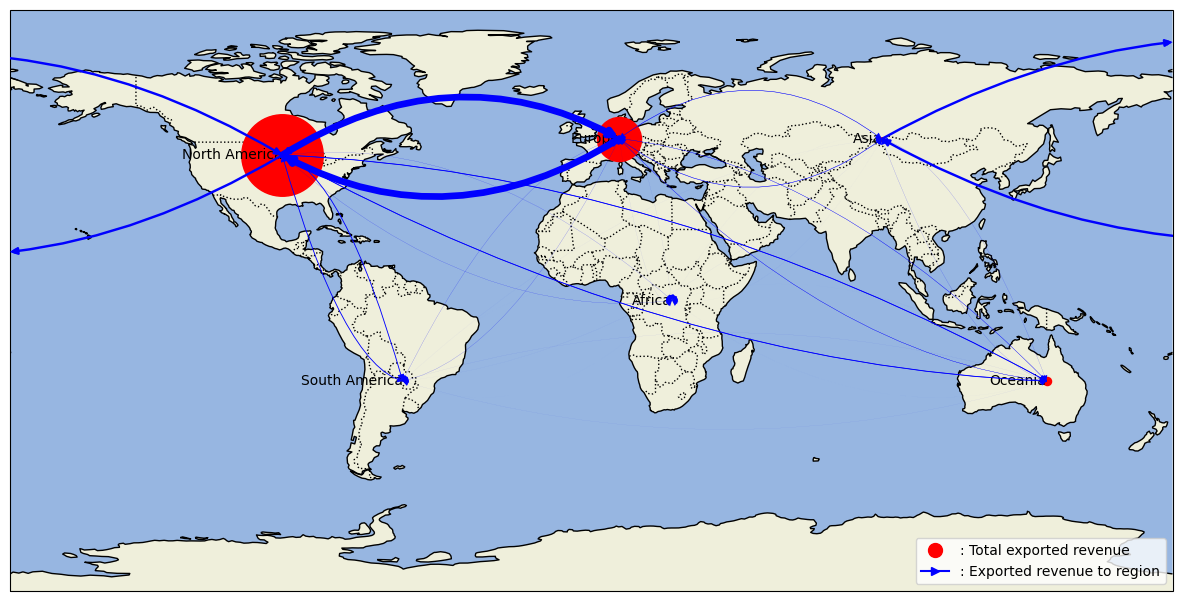

In [349]:
# Step 6: Visualize the Graph
fig, ax = plt.subplots(
    figsize=(15, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

# Add map features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the extent of the map to include all the points
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Normalize edge weights
edge_weights = np.array([data['weight'] for _, _, data in G.edges(data=True)])
edge_weights_norm = 5 * edge_weights / edge_weights.max()

# Normalize node sizes
node_sizes = {node: G.out_degree(node, weight='weight') for node in G.nodes()}
max_size = max(node_sizes.values())
node_sizes_transformed = {node: 50 * size / max_size for node, size in node_sizes.items()}

# Draw nodes with adjusted sizes
for node, (lon, lat) in pos.items():
    size = node_sizes_transformed.get(node, 0)  
    ax.plot(lon, lat, marker='o', color='red', markersize=15*np.log(size), transform=ccrs.Geodetic())
    ax.text(lon, lat, node, verticalalignment='center', horizontalalignment='right', transform=ccrs.Geodetic())

# Get the maximum weight for normalization
max_weight = max(nx.get_edge_attributes(G, 'weight').values())

# Draw edges with Bezier curves
for (u, v, data) in G.edges(data=True):
    if u != v :  # Skip self-loops for visualization
        start_pos, end_pos = pos[u], pos[v]
        weight = data['weight']
        normalized_weight = 15 * weight / max_weight  

        if ((u=='North America' and v=='Asia') or (u=='Asia' and v=='North America')):
            draw_global_edge(ax, pos['Asia'], pos['North America'], color='blue', lw=normalized_weight)
            draw_global_edge(ax, pos['North America'], pos['Asia'], color='blue', lw=normalized_weight)

        else :
            # Offset the control points for bidirectional edges
            control_point = offset_control_point(start_pos, end_pos, offset=30)
            control_point_reverse = offset_control_point(start_pos, end_pos, offset=-30)

            # Draw edge from u to v
            draw_bezier_arrow(ax, start_pos, end_pos, control_point, color='blue', lw=normalized_weight, zorder=10)
            # Draw edge from v to u
            draw_bezier_arrow(ax, end_pos, start_pos, control_point_reverse, color='blue', lw=normalized_weight, zorder=10)

# Create a custom legend entry for nodes
node_legend = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=10, label=': Total exported revenue')

# Create a custom legend entry for edges
edge_legend = mlines.Line2D([], [], color='blue', marker='>', linestyle='-', label=': Exported revenue to region')

# Add the legend to the plot
ax.legend(handles=[node_legend, edge_legend], loc='lower right')  # You can change the location as needed


plt.show()

In [273]:
import folium
from folium import Marker
import geopandas as gpd
from shapely.geometry import Point, LineString
import pandas as pd
import plotly.graph_objects as go

In [274]:
# Positions of the regions
pos = {
    'North America': (-95.7129, 45),
    'Europe': (8.6821, 50.1109),
    'South America': (-58.3816, -25),
    'Asia': (90, 50),
    'Africa': (25, 0),
    'Oceania': (141.0, -25.0)
}

# Create a Plotly figure
fig = go.Figure()

# Compute node weights
node_weights = {node: 0 for node in pos.keys()}
for _, row in region_to_region_df.iterrows():
    node_weights[row['co_production_region']] += row['divided_gross']
    node_weights[row['success_region']] += row['divided_gross']

# Normalize the weights
max_weight = max(node_weights.values())
for node in node_weights:
    node_weights[node] = 15 * node_weights[node] / max_weight

# Add nodes with hover information
for region, (lon, lat) in pos.items():
    node_weight = node_weights[region]
    formatted_weight = "{:,}".format(int(node_weight*max_weight/15)).replace(",", "'")
    node_text = f"Region: {region}, Weight: {formatted_weight}"  
    adjusted_weight = max(node_weight, 1) 
    fig.add_trace(go.Scattergeo(
        lon = [lon],
        lat = [lat],
        hoverinfo = 'text',
        text = node_text,  
        mode = 'markers',
        marker = dict(size = 15 * np.log(adjusted_weight), color = 'red'),
    ))

# Add edges
for _, row in region_to_region_df.iterrows():
    start = pos[row['co_production_region']]
    end = pos[row['success_region']]
    weight = row['divided_gross'] / region_to_region_df['divided_gross'].max() * 15

    # Edge trace with marker at the end to indicate direction
    fig.add_trace(go.Scattergeo(
        lon=[start[0], end[0]],
        lat=[start[1], end[1]],
        mode='lines+markers',  # Add markers at the ends of the lines
        line=dict(width=weight, color='blue'),
        marker=dict(size=weight, color='blue', symbol='arrow-bar-up'),  
        hoverinfo='none'
    ))

fig.update_layout(
    title = 'Interactive Network Graph',
    showlegend = False,
    geo = dict(
        projection_type = 'natural earth',
        showland = True,
        landcolor = 'lightgreen', 
        countrycolor = 'gray',     
    )
)

fig.show()

# Export to HTML
html_file_path = 'docs/plots/graph_region.html'
fig.write_html(html_file_path)

print(f"Graph exported as HTML to {html_file_path}")

Graph exported as HTML to docs/plots/graph_region.html


In [275]:
# data = {
#     'start': region_to_region_df['co_production_region'].tolist(),
#     'end': region_to_region_df['success_region'].tolist(),
#     'weight': region_to_region_df['divided_gross'].tolist()
# }

# # Calculate node weights
# node_weights = {node: 0 for node in pos.keys()}
# for _, row in region_to_region_df.iterrows():
#     node_weights[row['co_production_region']] += row['divided_gross']
#     node_weights[row['success_region']] += row['divided_gross']

# # Get the maximum weight for normalization
# max_weight = max(nx.get_edge_attributes(G, 'weight').values())

# # Positions of the regions
# pos = {
#     'North America': (-95.7129, 45),
#     'Europe': (8.6821, 50.1109),
#     'South America': (-58.3816, -25),
#     'Asia': (90, 50),
#     'Africa': (25, 0),
#     'Oceania': (141.0, -25.0)
# }

# # Create a GeoDataFrame for edges
# edges = gpd.GeoDataFrame(data)
# edges['geometry'] = edges.apply(lambda x: LineString([Point(pos[x['start']]), Point(pos[x['end']])]), axis=1)

# # Initialize a folium map
# m = folium.Map(location=[20, 0], zoom_start=2)

# # Add nodes to the map
# min_size = 5
# for region, coords in pos.items():
#     node_weight = node_weights.get(region, 0)
#     node_size = max(10 * np.log(30*node_weight / max_weight), min_size)
#     folium.CircleMarker(
#         location=[coords[1], coords[0]],
#         radius=node_size,
#         color='red',
#         fill=True
#     ).add_to(m)


# # Add edges to the map
# for _, row in edges.iterrows():
#     weight = row['weight'] / edges['weight'].max() * 15
#     start_coords = pos[row['start']]
#     end_coords = pos[row['end']]
    
#     # Add edge line
#     folium.PolyLine([(start_coords[1], start_coords[0]), 
#                      (end_coords[1], end_coords[0])], 
#                     color='blue', weight=weight).add_to(m)
    
#     # Calculate the angle of the line for arrow
#     angle = math.atan2(end_coords[1] - start_coords[1], end_coords[0] - start_coords[0])

# # Display the map
# m.save('map.html')
# m

In [276]:
# Filter out domestic gross
export_only_df = exploded_df[exploded_df['co_production_region'] != exploded_df['success_region']]

# Explode the 'genres' column to have one genre per row
exploded_df['genres'] = exploded_df['genres'].apply(lambda x: x if isinstance(x, list) else [])
genre_exploded_df = exploded_df.explode('genres')

# Group by region and genre, then sum the gross
region_genre_gross_df = genre_exploded_df.groupby(['co_production_region', 'genres'])['divided_gross'].sum().reset_index()

In [277]:
from plotly.subplots import make_subplots

In [278]:
def prepare_data(df, explode_column):
    df = df.copy()

    # Explode the 'genres' column to have one genre per row
    df['genres'] = df['genres'].apply(lambda x: x if isinstance(x, list) else [])
    genre_exploded_df = df.explode('genres')

    # Group by region and genre, then sum the gross
    region_genre_gross_df = genre_exploded_df.groupby([explode_column, 'genres'])['divided_gross'].sum().reset_index()

    return region_genre_gross_df

def identify_top_genres(df, n=15):
    return df.groupby('genres')['divided_gross'].sum().nlargest(n).index

def modify_dataframe(df, column, top_genres):
    modified_df = pd.DataFrame()
    
    for group in df[column].unique():
        # Filter dataframe for the current group
        df_group = df[df[column] == group]

        # Select rows with top genres and sum the rest as 'Other'
        top_genres_df = df_group[df_group['genres'].isin(top_genres)]
        other_gross = df_group[~df_group['genres'].isin(top_genres)]['divided_gross'].sum()
        other_row = pd.DataFrame({column: [group], 'genres': ['Other'], 'divided_gross': [other_gross]})

        # Combine top genres and 'Other' row
        modified_df = pd.concat([modified_df, top_genres_df, other_row], ignore_index=True)

    return modified_df

def plot_pie_charts(df, column, title, filename):
    # Create the 2x3 grid layout
    fig = make_subplots(rows=2, cols=3, specs=[[{'type':'pie'}, {'type':'pie'}, {'type':'pie'}],
                                               [{'type':'pie'}, {'type':'pie'}, {'type':'pie'}]],
                        subplot_titles=df[column].unique())

    # Track which cell we are plotting in
    row, col = 1, 1

    # Plot each region's pie chart
    for region in df[column].unique():
        df_region = df[df[column] == region]
        fig.add_trace(go.Pie(labels=df_region['genres'], values=df_region['divided_gross'] / 1000000, name=region, sort=False,
                             hovertemplate= "Genre: %{label}<br>Revenue: %{value:,d}M<br>%{percent}<extra></extra>", textinfo="none"), row=row, col=col)        
        # Update row and column indices for the next plot
        col += 1
        if col > 3:
            col = 1
            row += 1

    # Update layout for a shared legend and adjust it to your preference
    fig.update_layout(showlegend=True, legend_title_text='Genres')

    # Add a general title and adjust the margins to create more space between the titles and the charts
    fig.update_layout(
        title_text=title,  
        title_x=0.5,  # Center the general title
        margin=dict(t=120, l=20, r=20, b=20)  # Adjust top margin to increase space
    )

    # Adjust the position of each subplot title to add more space
    for i in range(len(df[column].unique())):
        fig.layout.annotations[i].update(y=fig.layout.annotations[i].y + 0.05)

    # Show the figure
    fig.show()

    # Export to HTML
    fig.write_html(filename)

# Exported genres

In [279]:
# Filter out domestic gross
column_treated = 'co_production_region'
export_only_df = exploded_df[exploded_df[column_treated] != exploded_df['success_region']]

prepared_df = prepare_data(export_only_df, column_treated)
top_genres = identify_top_genres(prepared_df, 10)
modified_df = modify_dataframe(prepared_df, column_treated, top_genres)

plot_pie_charts(modified_df, column_treated, 'Most exported genres per region', 'docs/plots/pie_chart_exported.html')

# Most watched genre

In [280]:
column_treated = 'success_region'

prepared_df = prepare_data(exploded_df, column_treated)
top_genres = identify_top_genres(prepared_df, 10)
modified_df = modify_dataframe(prepared_df, column_treated, top_genres)

plot_pie_charts(modified_df, column_treated, 'Most watched genres per region', 'docs/plots/pie_chart_watched.html')